In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Conv1D, BatchNormalization, Activation,
    Add, GlobalAveragePooling1D
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    # shortcut 차원 맞추기
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

In [9]:
inputs = Input(shape=(n_timesteps, n_features))
x = LSTM(128, return_sequences=True)(inputs)
x = resnet_block(x, 128)
x = resnet_block(x, 64)
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

lstm_resnet_model = Model(inputs, outputs)
lstm_resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     70,656 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 128)  │     49,280 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 128)  │     49,280 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128)  │          0 │ lstm[0][0],       │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │     24,640 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │      8,256 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 64)   │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 64)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_3[0][

 Total params: 252,614 (986.77 KB)

 Trainable params: 251,718 (983.27 KB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
model_history = lstm_resnet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 46s 239ms/step - accuracy: 0.8073 - loss: 0.5230 - val_accuracy: 0.3107 - val_loss: 2.4933
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.9328 - loss: 0.1829 - val_accuracy: 0.8642 - val_loss: 0.3527
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 241ms/step - accuracy: 0.9454 - loss: 0.1450 - val_accuracy: 0.8879 - val_loss: 0.3484
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.9457 - loss: 0.1421 - val_accuracy: 0.9372 - val_loss: 0.1721
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.9436 - loss: 0.1369 - val_accuracy: 0.9406 - val_loss: 0.1428
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.9480 - loss: 0.1215 - val_accuracy: 0.8964 - val_loss: 0.2336
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.9496 - loss: 0.1229 - val_accuracy: 0.9304 - val_loss: 0.1732
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 39s 231ms/step - accuracy: 0.9406 - loss: 0

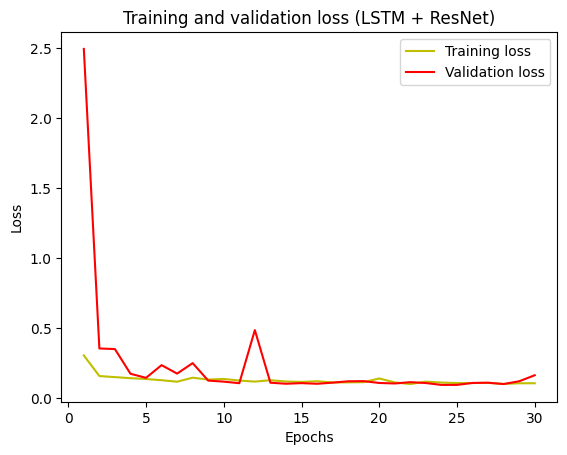

In [11]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (LSTM + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

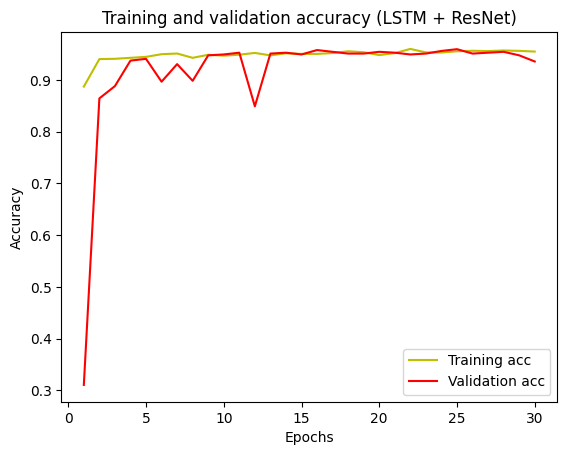

In [12]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (LSTM + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step
[[436   1  59   0   0   0]
 [  0 398  72   1   0   0]
 [  0   0 420   0   0   0]
 [  0  21   1 315 152   2]
 [  0   0   1  40 491   0]
 [  0   0   0   0   0 537]]
0.8812351543942993
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       496
           1       0.95      0.85      0.89       471
           2       0.76      1.00      0.86       420
           3       0.88      0.64      0.74       491
           4       0.76      0.92      0.84       532
           5       1.00      1.00      1.00       537

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

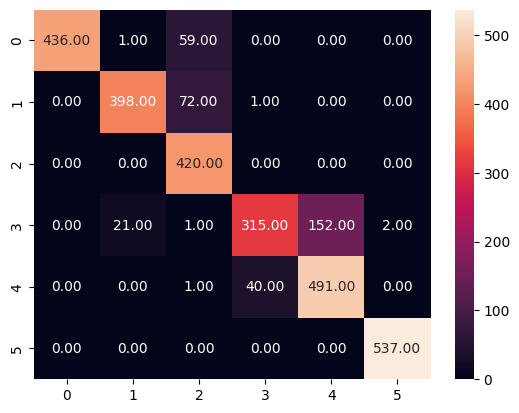

In [13]:
pred = lstm_resnet_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')